In [20]:
import sys
import os
import os.path as osp
sys.path.insert(0, osp.join('..', 'main'))
sys.path.insert(0, osp.join('..', 'data'))
sys.path.insert(0, "../main/transformer_utils")
import argparse
import numpy as np
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch
from config import cfg
import cv2
import pdb

%matplotlib inline

from common.base import Demoer
from common.utils.preprocessing import load_img, process_bbox, generate_patch_image
from common.utils.vis import render_mesh, save_obj, vis_keypoints

from main.render_p3d import base_renderer


os.environ["PYOPENGL_PLATFORM"] = "egl"






gpu_id = '0'
encoder_setting='osx_l'
decoder_setting='normal'
pretrained_model_path='../output/train_smil_detachshape/model_dump/snapshot_40.pth.tar'
model_type='smil_h'

cfg.set_args(gpu_id)
cfg.set_additional_args(
    encoder_setting=encoder_setting, 
    decoder_setting=decoder_setting, 
    pretrained_model_path=pretrained_model_path,
    model_type=model_type)

cudnn.benchmark = True



if model_type == 'smpl_h':
    from common.utils.human_models import smpl_h as smpl
elif model_type == 'smpl_x':
    from common.utils.human_models import smpl_x as smpl
elif model_type == 'smil_h':
    from common.utils.human_models import smil_h as smpl
else:
    raise NotImplementedError()







>>> Using GPU: 0


In [21]:
output_folder = '../ut/test_new_render'
os.makedirs(output_folder, exist_ok=True)

# prepare input image
transform = transforms.ToTensor()
img_path = 'data/peiran/images/1.jpg'
original_img = load_img(img_path)
original_img_height, original_img_width = original_img.shape[:2]




# detect human bbox with yolov5s

detector = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
with torch.no_grad():
    results = detector(original_img)
person_results = results.xyxy[0][results.xyxy[0][:, 5] == 0]
class_ids, confidences, boxes = [], [], []
for detection in person_results:
    x1, y1, x2, y2, confidence, class_id = detection.tolist()
    class_ids.append(class_id)
    confidences.append(confidence)
    boxes.append([x1, y1, x2 - x1, y2 - y1])
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
vis_mesh = original_img.copy()
vis_kpts = original_img.copy()




requirements: Ultralytics requirements ['requests>=2.32.2', 'tqdm>=4.66.3', 'setuptools>=70.0.0'] not found, attempting AutoUpdate...


Using cache found in /home/x_hensh/.cache/torch/hub/ultralytics_yolov5_master
ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '/software/sse/manual/PyTorch/2.3.0/python-3.10/envs/pytorch_2.3.0/lib/python3.10/site-packages/tqdm'



Retry 1/2 failed: Command 'pip install --no-cache-dir "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.


ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '/software/sse/manual/PyTorch/2.3.0/python-3.10/envs/pytorch_2.3.0/lib/python3.10/site-packages/tqdm'



Retry 2/2 failed: Command 'pip install --no-cache-dir "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.
requirements: ❌ Command 'pip install --no-cache-dir "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.


YOLOv5 🚀 2024-12-10 Python-3.10.0 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-40GB, 40339MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [22]:

demoer = Demoer()
demoer._make_model(smpl)
demoer.model.eval()

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


02-08 11:02:23 Load checkpoint from ../output/train_smil_detachshape/model_dump/snapshot_40.pth.tar
02-08 11:02:23 Load checkpoint from ../output/train_smil_detachshape/model_dump/snapshot_40.pth.tar
02-08 11:02:23 Creating graph...
02-08 11:02:23 Creating graph...


1


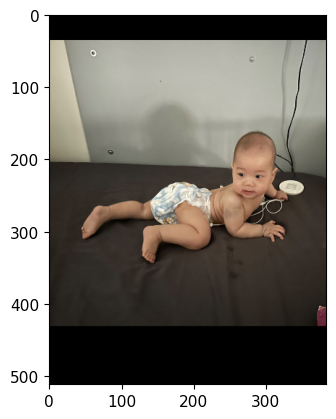

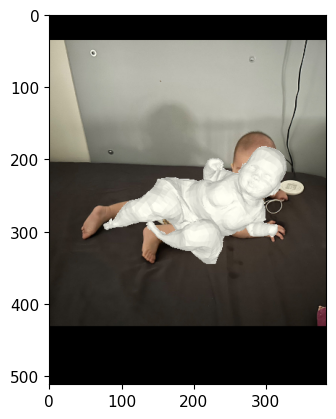

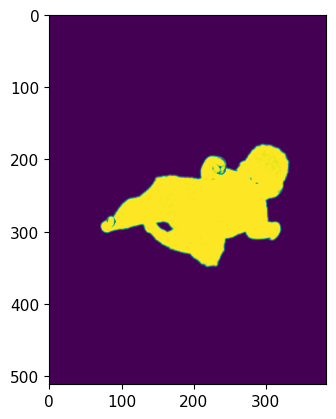

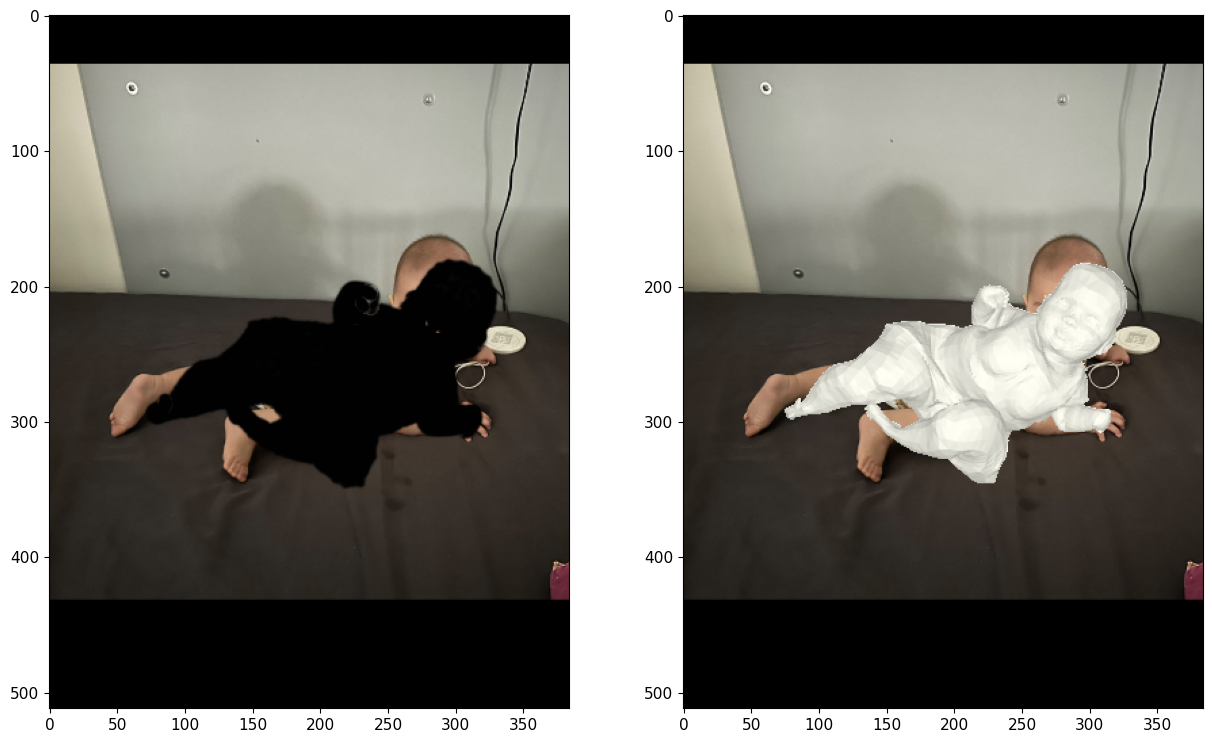

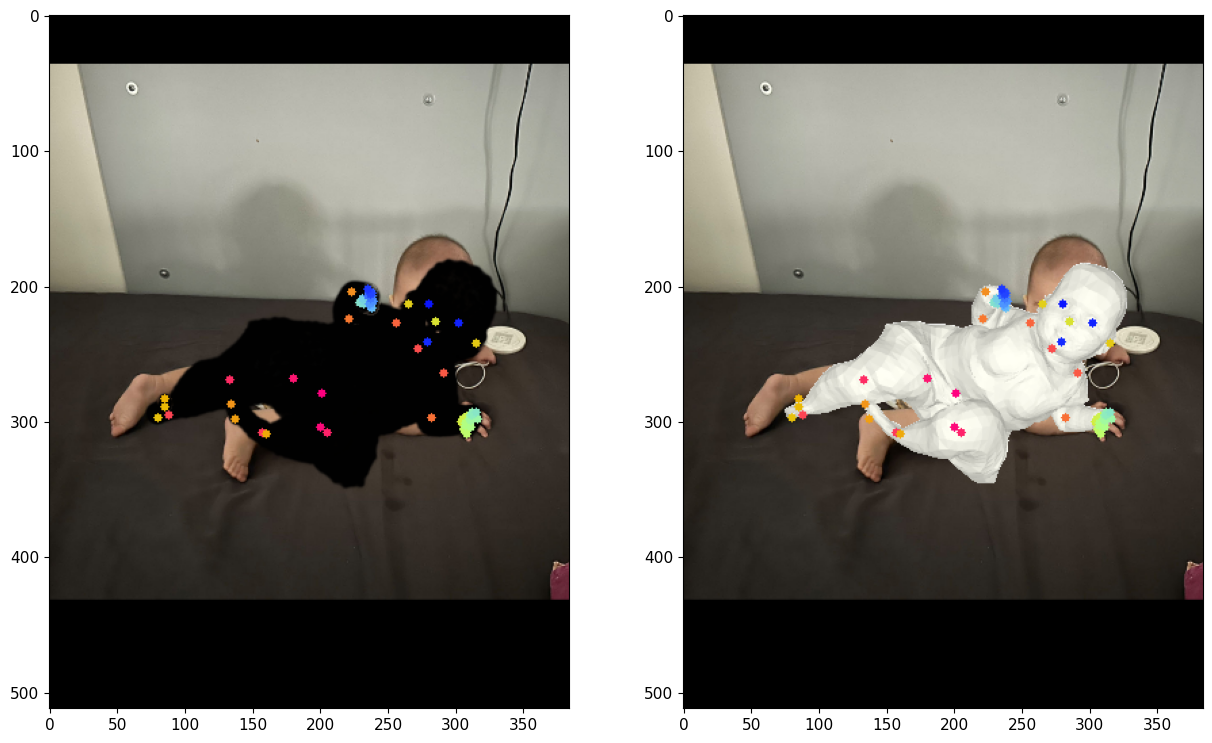

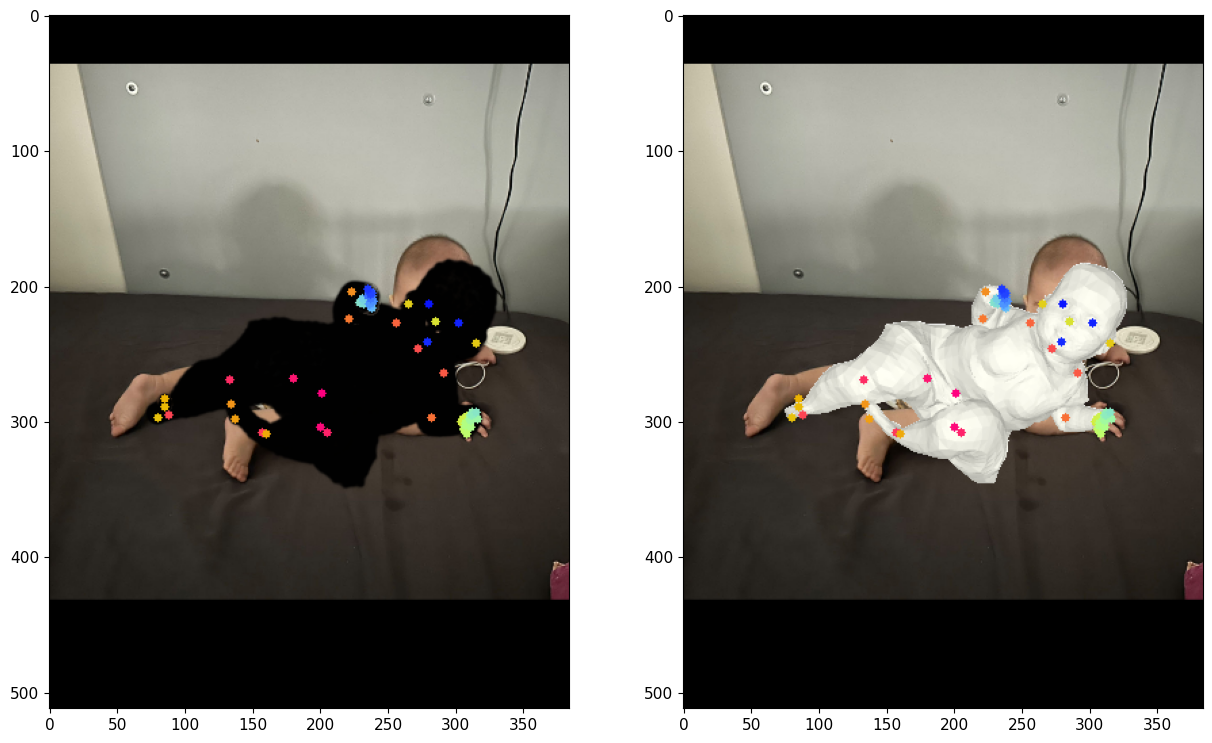

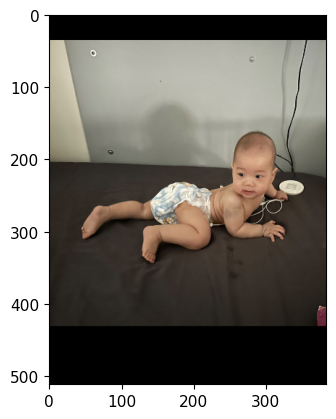

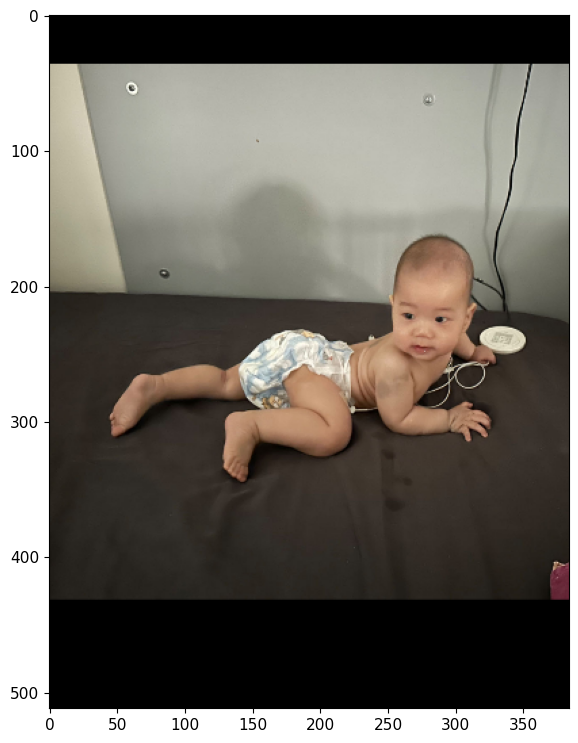

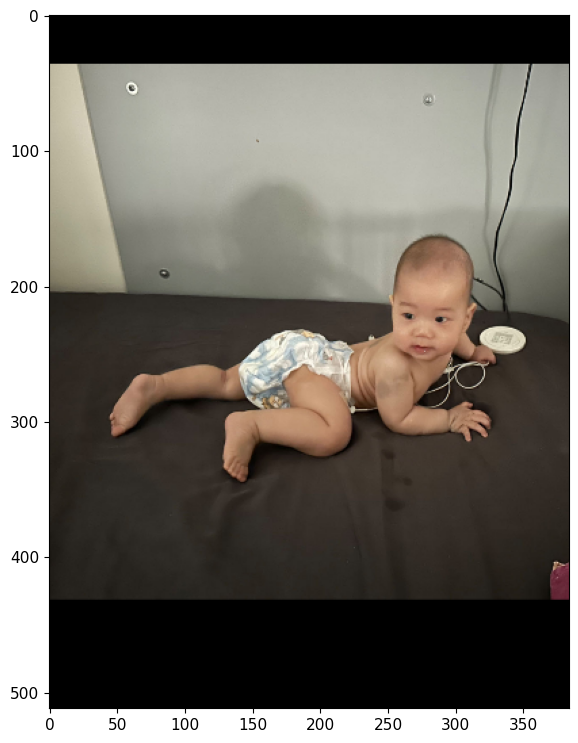

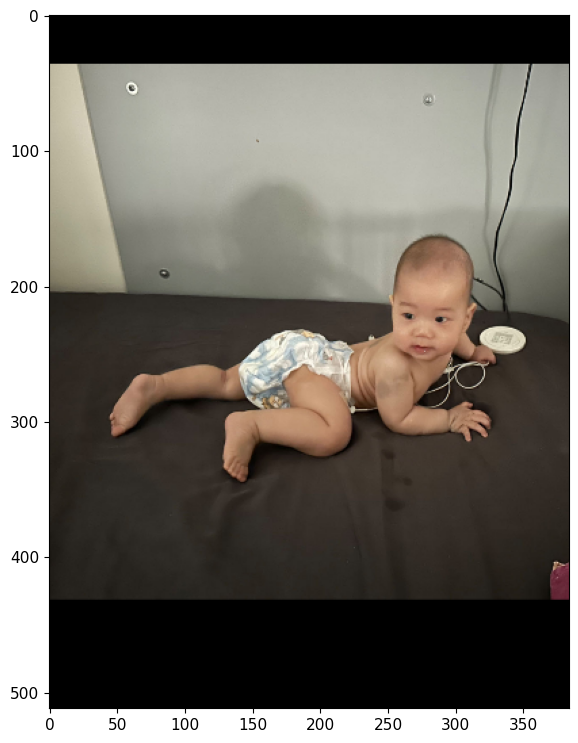

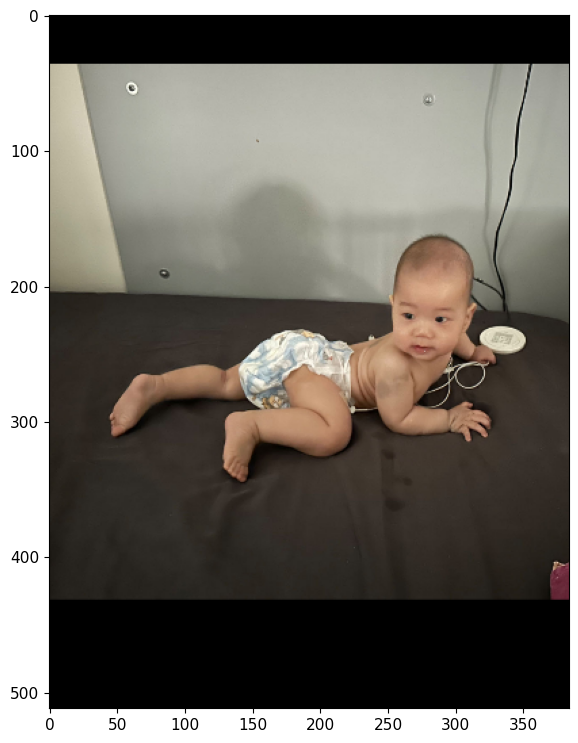

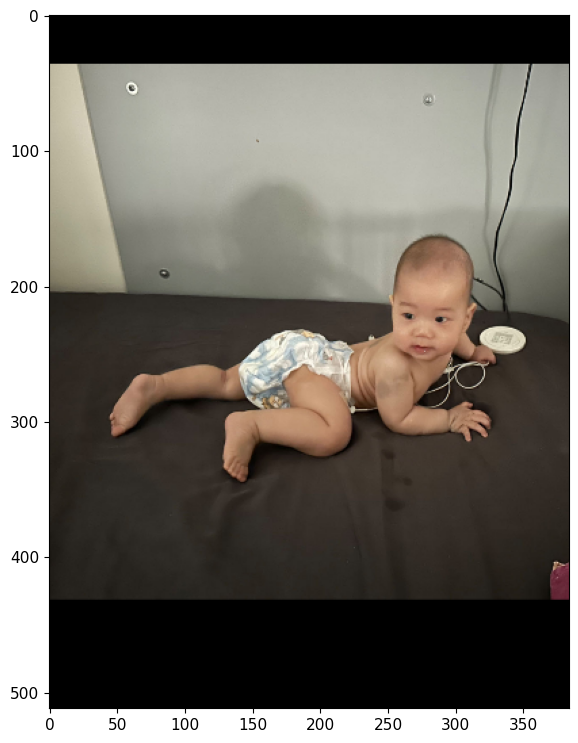

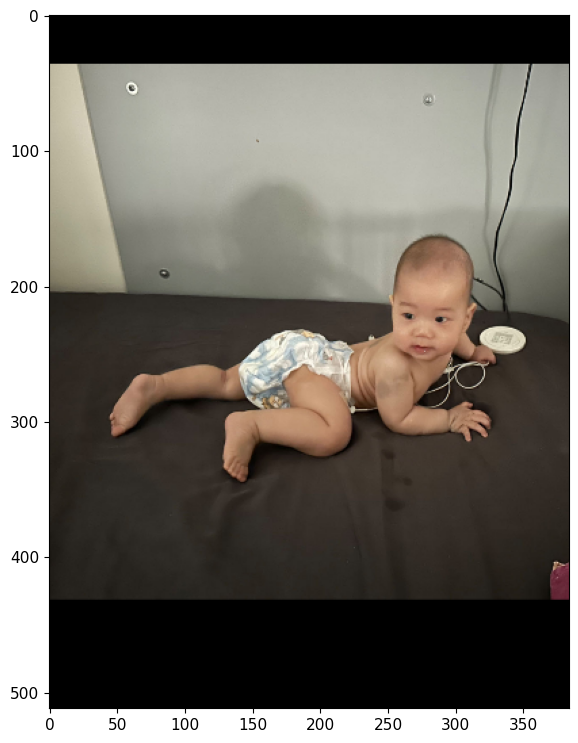

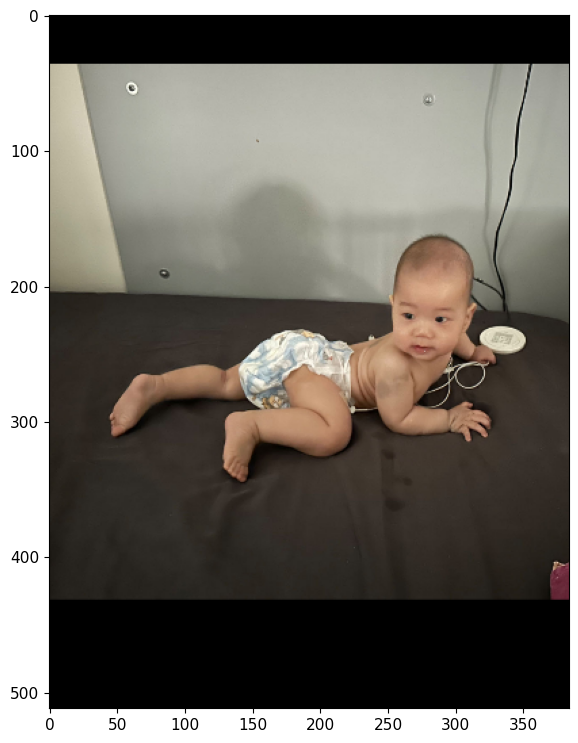

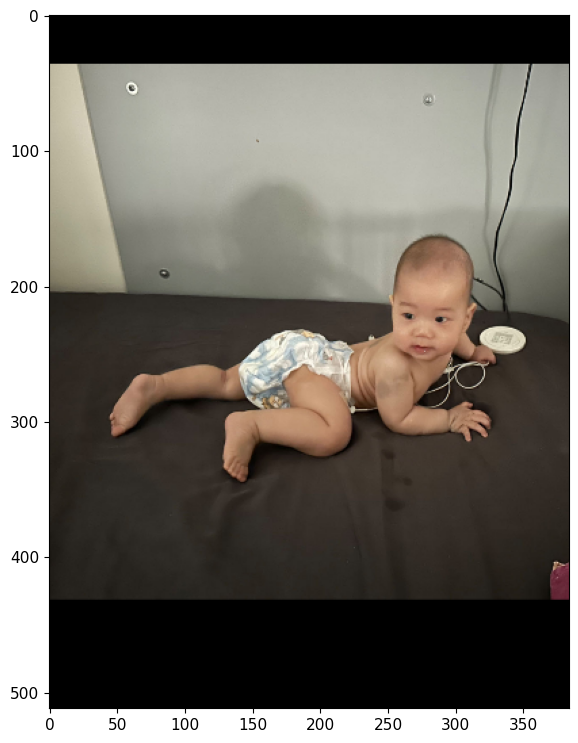

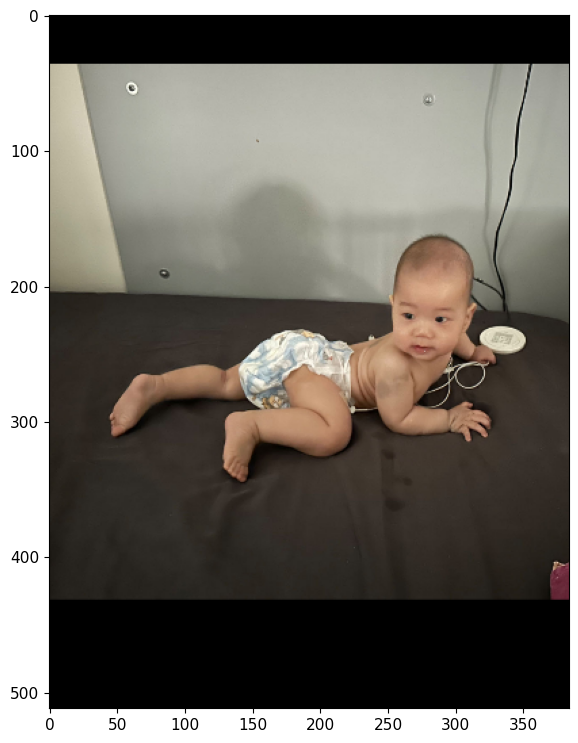

In [23]:
num_detected = len(indices)
print (num_detected)

import matplotlib.pyplot as plt
bbox = boxes[0]
bbox = process_bbox(bbox, original_img_width, original_img_height)
input_img_psn_np, img2bb_trans, bb2img_trans = generate_patch_image(original_img, bbox, 1.0, 0.0, False, cfg.input_img_shape)

fig, ax = plt.subplots(figsize=(15,9))
ax.imshow(input_img_psn_np.astype('uint8'))
plt.show()













# save rendered image
#cv2.imwrite(os.path.join(args.output_folder, f'render.jpg'), vis_mesh[:, :, ::-1])
#cv2.imwrite(os.path.join(args.output_folder, f'kpts.jpg'), vis_kpts[:, :, ::-1])

In [24]:
input_img_psn_ts = transform(input_img_psn_np.astype(np.float32))/255
input_img_psn_ts = input_img_psn_ts.cuda()[None,:,:,:]
inputs = {'img': input_img_psn_ts}
targets = {}
meta_info = {}

with torch.no_grad():
    out = demoer.model(inputs, targets, meta_info, 'test')


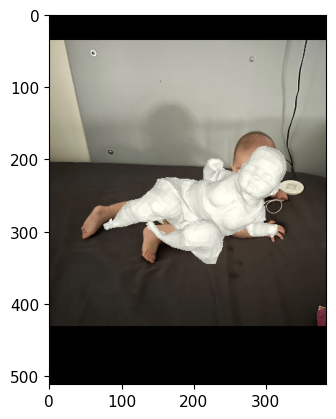

In [25]:
mesh = out['smplx_mesh_cam'][0]
points = out['joint_cam_tr'][0, ...]

   
focal = [
    cfg.focal[0] / cfg.input_body_shape[1] * cfg.input_img_shape[1], 
    cfg.focal[1] / cfg.input_body_shape[0] * cfg.input_img_shape[0]
]
    
princpt = [
    cfg.princpt[0] / cfg.input_body_shape[1] * cfg.input_img_shape[1], # / cfg.input_body_shape[1], 
    cfg.princpt[1] / cfg.input_body_shape[0] * cfg.input_img_shape[0]# / cfg.input_body_shape[0]
]

vis_mesh_psn_np = input_img_psn_np.copy()

vis_mesh_psn_np = render_mesh(vis_mesh_psn_np, mesh.cpu().numpy(), smpl.face, {'focal': focal, 'princpt': princpt})

joint_proj = out['smplx_joint_proj'].detach().cpu().numpy()[0]
joint_proj[:, 0] = joint_proj[:, 0] / cfg.output_hm_shape[2] * cfg.input_img_shape[1]
joint_proj[:, 1] = joint_proj[:, 1] / cfg.output_hm_shape[1] * cfg.input_img_shape[0]
joint_proj = np.concatenate((joint_proj, np.ones_like(joint_proj[:, :1])), 1)
#vis_mesh_psn_np = vis_keypoints(vis_mesh_psn_np, joint_proj)



fig, ax = plt.subplots()
ax.imshow(vis_mesh_psn_np.astype('uint8'))
plt.show()


torch.Size([1, 512, 384, 4])


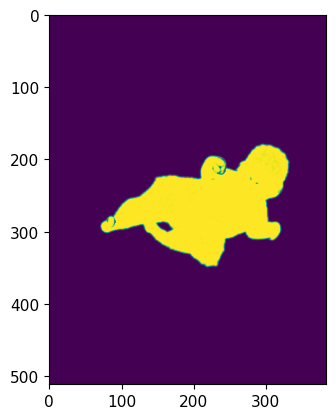

In [26]:
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, SoftSilhouetteShader,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,PerspectiveCameras, HardPhongShader,PointLights,TexturesVertex
)
device = 'cuda'

R = torch.tensor(
    [[-1, 0, 0],
     [0, -1, 0],                             
     [0, 0, 1]]).repeat(1, 1, 1).to(device)
T = torch.zeros(3).repeat(1, 1).to(device)


camera_screen = PerspectiveCameras(
    focal_length=[focal,], 
    principal_point=[princpt,], 
    in_ndc=False, 
    image_size=[cfg.input_img_shape,],
    device=device, 
    R=R, 
    T=T)


blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

raster_settings = RasterizationSettings(
            image_size=cfg.input_img_shape,
            blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
            faces_per_pixel=100,
            perspective_correct=False,
)

silhouette_renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=camera_screen,
                raster_settings=raster_settings
            ),
            shader=SoftSilhouetteShader(blend_params=blend_params)
)


#pdb.set_trace()

torch_mesh = Meshes(verts=mesh.unsqueeze(0).to(device),
                    faces=torch.from_numpy(smpl.face.astype('int')).unsqueeze(0).to(device))
        
silhouette = silhouette_renderer(meshes_world=torch_mesh.clone(), R=R, T=T)#[..., -1]
#screen_size = torch.ones(1, 2) * torch.Tensor(self.size) #torch.ones(vertices.shape[0],2)
#screen_size = screen_size.to(self.device)#torch.ones(1, 2).to(self.device) * self.size #torch.ones(vertices.shape[0],2)

#print (silhuette)

print (silhouette.shape)
silhouette = silhouette[0, :, :, 3]
fig, ax = plt.subplots()
ax.imshow(silhouette.cpu().numpy())
plt.show()

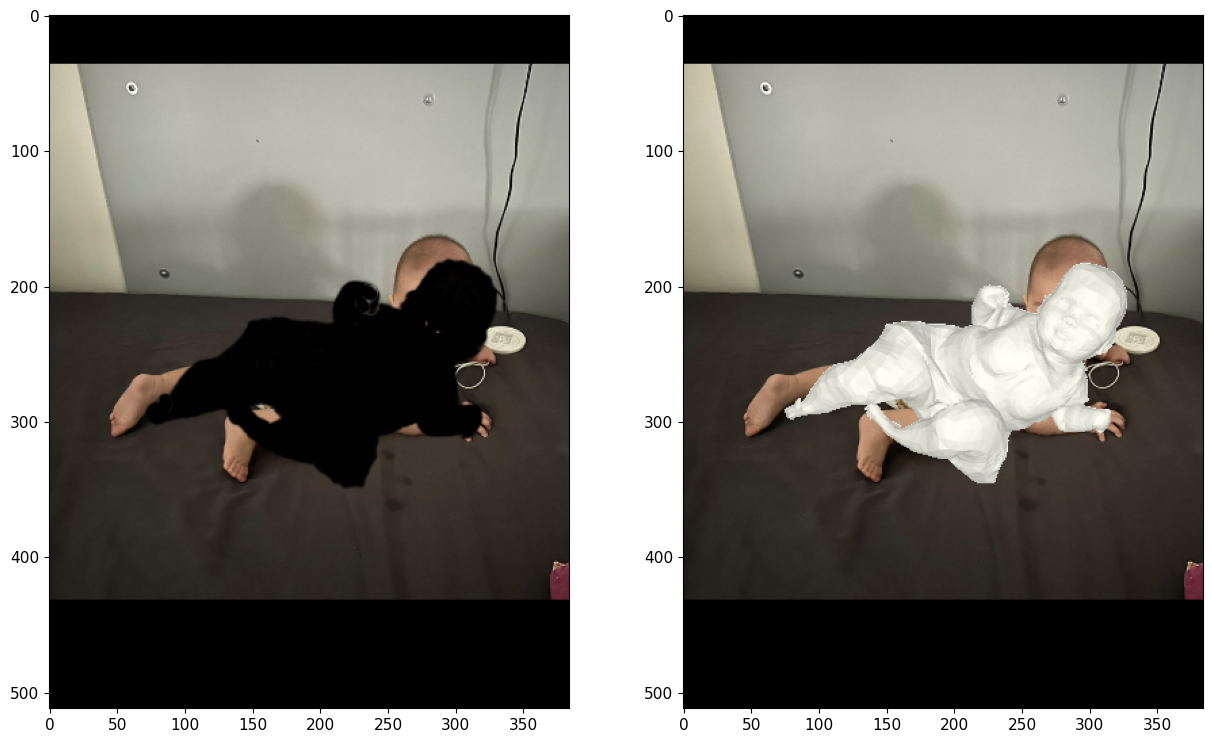

In [27]:
#print (np.multiply(input_img, 1 - np.expand_dims(silhouette[0, :,:,3].cpu().numpy(), -1)) )
#input_img = np.multiply(input_img, 1 - np.expand_dims(silhouette[0, :,:,3].cpu().numpy(), -1))
rendered =np.multiply(input_img_psn_np, 1 - np.expand_dims(silhouette.cpu().numpy(), -1)) + np.expand_dims(silhouette.cpu().numpy(), -1)

fig, ax = plt.subplots(1,2, figsize=(15, 9))
ax[0].imshow(rendered.astype('uint8'))
ax[1].imshow(vis_mesh_psn_np.astype('uint8'))
plt.show()

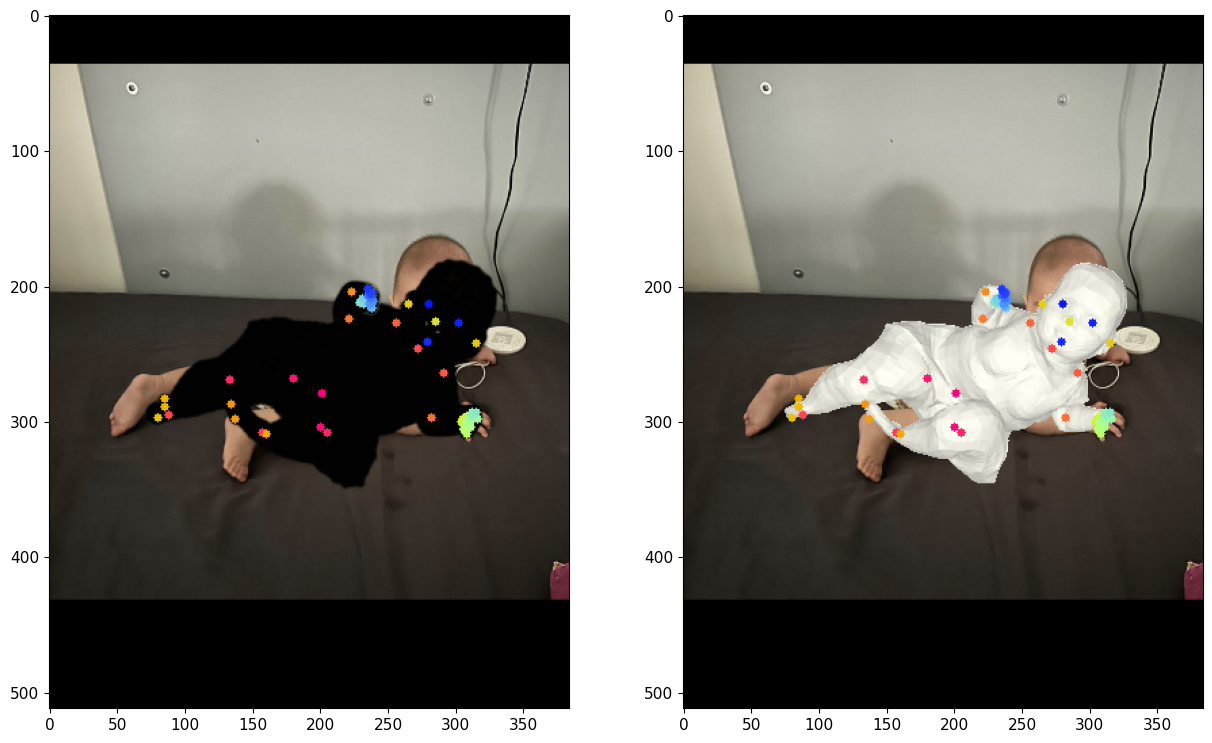

In [28]:
screen_size = torch.ones(1, 2) * torch.Tensor(torch.Tensor(cfg.input_img_shape)) #torch.ones(vertices.shape[0],2)
screen_size = screen_size.to(device)#torch.ones(1, 2).to(self.device) * self.size #torch.ones(vertices.shape[0],2)


proj_points = camera_screen.transform_points_screen(points.cpu().unsqueeze(0).to(device), image_size=screen_size)[0, :, :2]

rendered = vis_keypoints(rendered, proj_points.cpu().numpy())
vis_mesh_psn_np = vis_keypoints(vis_mesh_psn_np, proj_points.cpu().numpy())





fig, ax = plt.subplots(1,2, figsize=(15, 9))
ax[0].imshow(rendered.astype('uint8'))
ax[1].imshow(vis_mesh_psn_np.astype('uint8'))
plt.show()

